# importaciones

In [ ]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt

# creación modelo

In [ ]:
class DQNNetwork(nn.Module):
    """Red neuronal para el agente DQN."""

    def __init__(self, input_dim, output_dim):
        super(DQNNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# DQN entrenamiento

Episode: 100, Epsilon: 0.61, Best Reward: -8.2, Mean Reward: -270.7
Episode: 200, Epsilon: 0.37, Best Reward: 43.7, Mean Reward: -205.4
Episode: 300, Epsilon: 0.22, Best Reward: 43.7, Mean Reward: -295.4
Episode: 400, Epsilon: 0.13, Best Reward: 43.7, Mean Reward: -323.3
Episode: 500, Epsilon: 0.08, Best Reward: 43.7, Mean Reward: -323.1
Episode: 600, Epsilon: 0.05, Best Reward: 43.7, Mean Reward: -350.7
Episode: 700, Epsilon: 0.05, Best Reward: 43.7, Mean Reward: -392.4
Episode: 800, Epsilon: 0.05, Best Reward: 43.7, Mean Reward: -353.0
Episode: 900, Epsilon: 0.05, Best Reward: 193.9, Mean Reward: -220.0
Episode: 1000, Epsilon: 0.05, Best Reward: 193.9, Mean Reward: -168.2


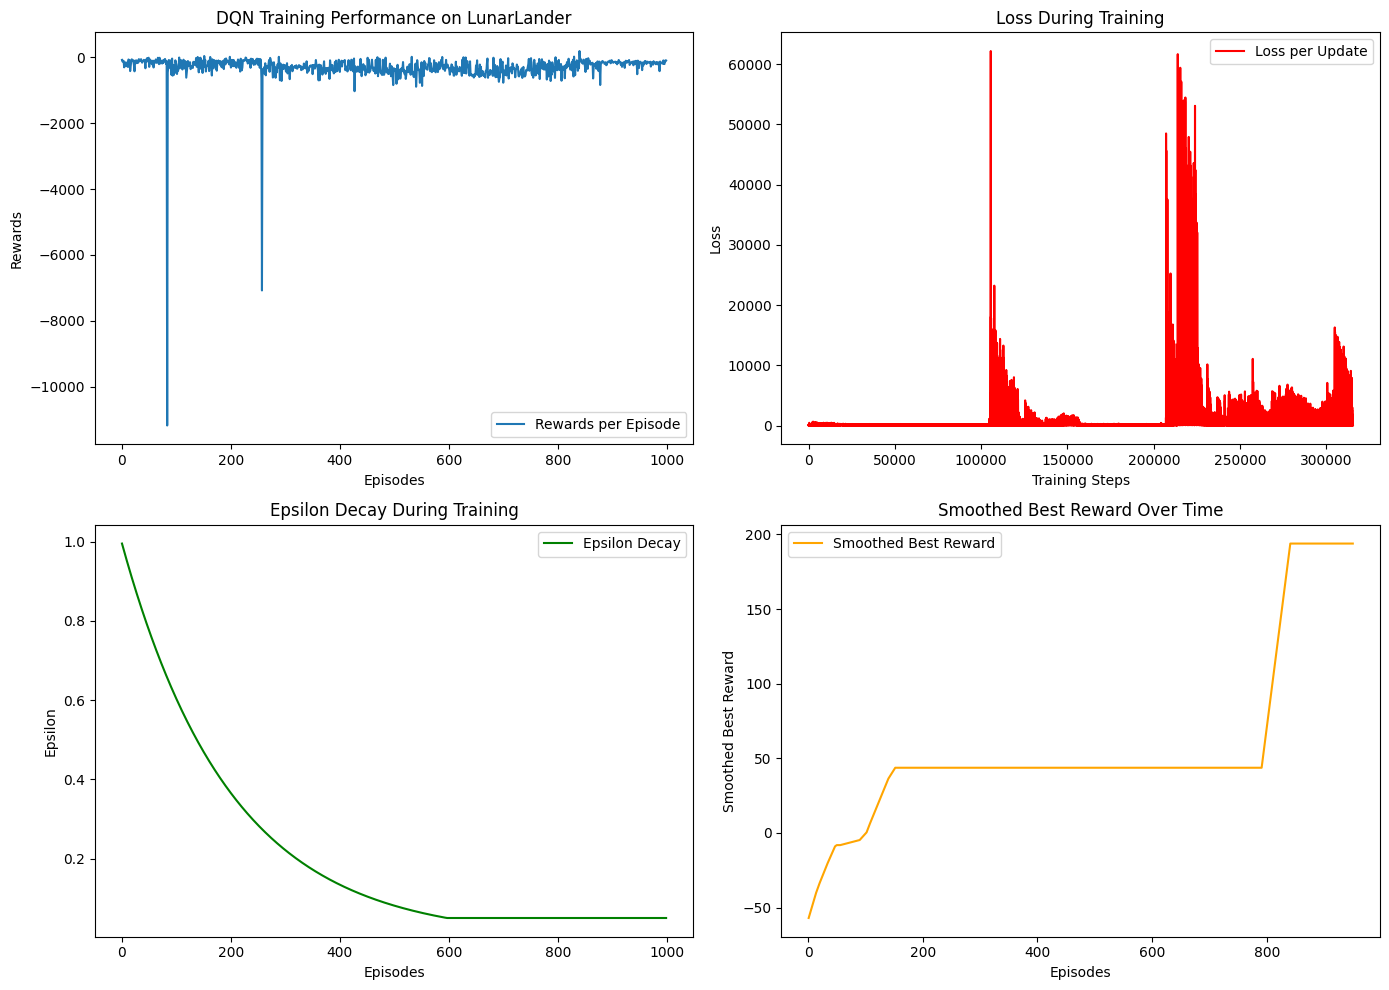

In [1]:
class DQNAgent:
    def __init__(self, env_name="LunarLander-v3", episodes=1000, gamma=0.99, lr=0.001):
        self.env = gym.make(env_name)
        self.episodes = episodes
        self.gamma = gamma
        self.lr = lr
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995
        self.memory = []
        self.batch_size = 64
        self.replay_buffer_capacity = 10000

        self.rewards_per_episode = []
        self.best_reward = -np.inf
        self.losses = []
        self.epsilon_values = []
        self.best_rewards_per_episode = []

        # Dimensiones
        input_dim = self.env.observation_space.shape[0]
        output_dim = self.env.action_space.n

        # Inicializar la red y optimizador
        self.network = DQNNetwork(input_dim, output_dim)
        self.target_network = DQNNetwork(input_dim, output_dim)
        self.target_network.load_state_dict(self.network.state_dict())
        self.target_network.eval()

        self.optimizer = optim.Adam(self.network.parameters(), lr=self.lr)
        self.loss_fn = nn.MSELoss()

    def store_transition(self, state, action, reward, next_state, done):
        """Almacenar experiencias en la memoria de replay."""
        if len(self.memory) > self.replay_buffer_capacity:
            self.memory.pop(0)
        self.memory.append((state, action, reward, next_state, done))

    def sample_memory(self):
        """Obtener un batch aleatorio de la memoria."""
        return random.sample(self.memory, self.batch_size)

    def select_action(self, state):
        """Seleccionar acción utilizando la política epsilon-greedy."""
        if random.random() < self.epsilon:
            return self.env.action_space.sample()  # Acción aleatoria
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            return torch.argmax(self.network(state)).item()

    def update_network(self):
        """Actualizar la red neuronal usando experiencias almacenadas."""
        if len(self.memory) < self.batch_size:
            return

        batch = self.sample_memory()
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(np.array(states), dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)

        q_values = self.network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.target_network(next_states).max(1)[0]
        expected_q_values = rewards + (1 - dones) * self.gamma * next_q_values

        loss = self.loss_fn(q_values, expected_q_values.detach())
        self.losses.append(loss.item())  # Guardar la pérdida

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def train(self):
        for episode in range(1, self.episodes + 1):
            state, _ = self.env.reset()
            done = False
            total_reward = 0

            while not done:
                action = self.select_action(state)
                next_state, reward, done, _, _ = self.env.step(action)
                self.store_transition(state, action, reward, next_state, done)
                self.update_network()

                state = next_state
                total_reward += reward

            self.rewards_per_episode.append(total_reward)
            self.best_rewards_per_episode.append(
                self.best_reward
            )  # Almacenar la mejor recompensa
            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
            self.epsilon_values.append(self.epsilon)  # Almacenar epsilon

            # Actualizar la red objetivo periódicamente
            if episode % 10 == 0:
                self.target_network.load_state_dict(self.network.state_dict())

            # Guardar el modelo si es la mejor recompensa
            if total_reward > self.best_reward:
                self.best_reward = total_reward
                self.save_model()

            # Imprimir métricas cada 100 episodios
            if episode % 100 == 0:
                mean_reward = np.mean(self.rewards_per_episode[-100:])
                print(
                    f"Episode: {episode}, Epsilon: {self.epsilon:.2f}, "
                    f"Best Reward: {self.best_reward:.1f}, Mean Reward: {mean_reward:.1f}"
                )

        self.plot_rewards()

    def save_model(self):
        """Guardar el modelo entrenado."""
        torch.save(self.network.state_dict(), "lunarlander_dqn_model.pth")

    def load_model(self):
        """Cargar el modelo entrenado."""
        self.network.load_state_dict(torch.load("lunarlander_dqn_model.pth"))
        self.network.eval()

    def plot_rewards(self):
        """Graficar las recompensas acumuladas y métricas del entrenamiento."""
        plt.figure(figsize=(14, 10))

        # Graficar recompensas por episodio
        plt.subplot(2, 2, 1)
        plt.plot(self.rewards_per_episode, label="Rewards per Episode")
        plt.xlabel("Episodes")
        plt.ylabel("Rewards")
        plt.title("DQN Training Performance on LunarLander")
        plt.legend()

        # Graficar la pérdida
        plt.subplot(2, 2, 2)
        plt.plot(self.losses, label="Loss per Update", color="red")
        plt.xlabel("Training Steps")
        plt.ylabel("Loss")
        plt.title("Loss During Training")
        plt.legend()

        # Graficar la Epsilon Decay
        plt.subplot(2, 2, 3)
        plt.plot(self.epsilon_values, label="Epsilon Decay", color="green")
        plt.xlabel("Episodes")
        plt.ylabel("Epsilon")
        plt.title("Epsilon Decay During Training")
        plt.legend()

        # Graficar la mejor recompensa suavizada
        plt.subplot(2, 2, 4)
        # Promedio móvil para suavizar la curva de mejores recompensas
        window_size = 50  # Tamaño de la ventana para el promedio móvil
        best_rewards_smooth = np.convolve(
            self.best_rewards_per_episode,
            np.ones(window_size) / window_size,
            mode="valid",
        )

        plt.plot(best_rewards_smooth, label="Smoothed Best Reward", color="orange")
        plt.xlabel("Episodes")
        plt.ylabel("Smoothed Best Reward")
        plt.title("Smoothed Best Reward Over Time")
        plt.legend()

        plt.tight_layout()
        plt.show()


# llamados entrenamiento

In [ ]:
if __name__ == "__main__":
    agent = DQNAgent(episodes=1000)
    agent.train()

# tensor

/home/topo/Documents/Universidad/2024-2/InteligentesII/Intelligent-II-DQN/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/topo/Documents/Universidad/2024-2/InteligentesII/Intelligent-II-DQN/.venv/lib/python3.10/site-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


Episode: 1, Epsilon: 0.99, Best Reward: -343.4, Mean Reward: -343.4
Episode: 2, Epsilon: 0.98, Best Reward: -343.4, Mean Reward: -448.9
Episode: 3, Epsilon: 0.98, Best Reward: -67.9, Mean Reward: -321.9
Episode: 4, Epsilon: 0.97, Best Reward: -67.9, Mean Reward: -263.7
Episode: 5, Epsilon: 0.97, Best Reward: -67.9, Mean Reward: -254.0
Episode: 6, Epsilon: 0.96, Best Reward: -67.9, Mean Reward: -231.3
Episode: 7, Epsilon: 0.96, Best Reward: -67.9, Mean Reward: -239.1
Episode: 8, Epsilon: 0.95, Best Reward: -67.9, Mean Reward: -235.5
Episode: 9, Epsilon: 0.95, Best Reward: -67.9, Mean Reward: -219.1
Episode: 10, Epsilon: 0.94, Best Reward: -67.9, Mean Reward: -217.4
Episode: 11, Epsilon: 0.94, Best Reward: -67.9, Mean Reward: -207.2
Episode: 12, Epsilon: 0.93, Best Reward: -67.9, Mean Reward: -199.4
Episode: 13, Epsilon: 0.93, Best Reward: -67.9, Mean Reward: -197.8
Episode: 14, Epsilon: 0.92, Best Reward: -67.9, Mean Reward: -190.1
Episode: 15, Epsilon: 0.92, Best Reward: -67.9, Mean Re

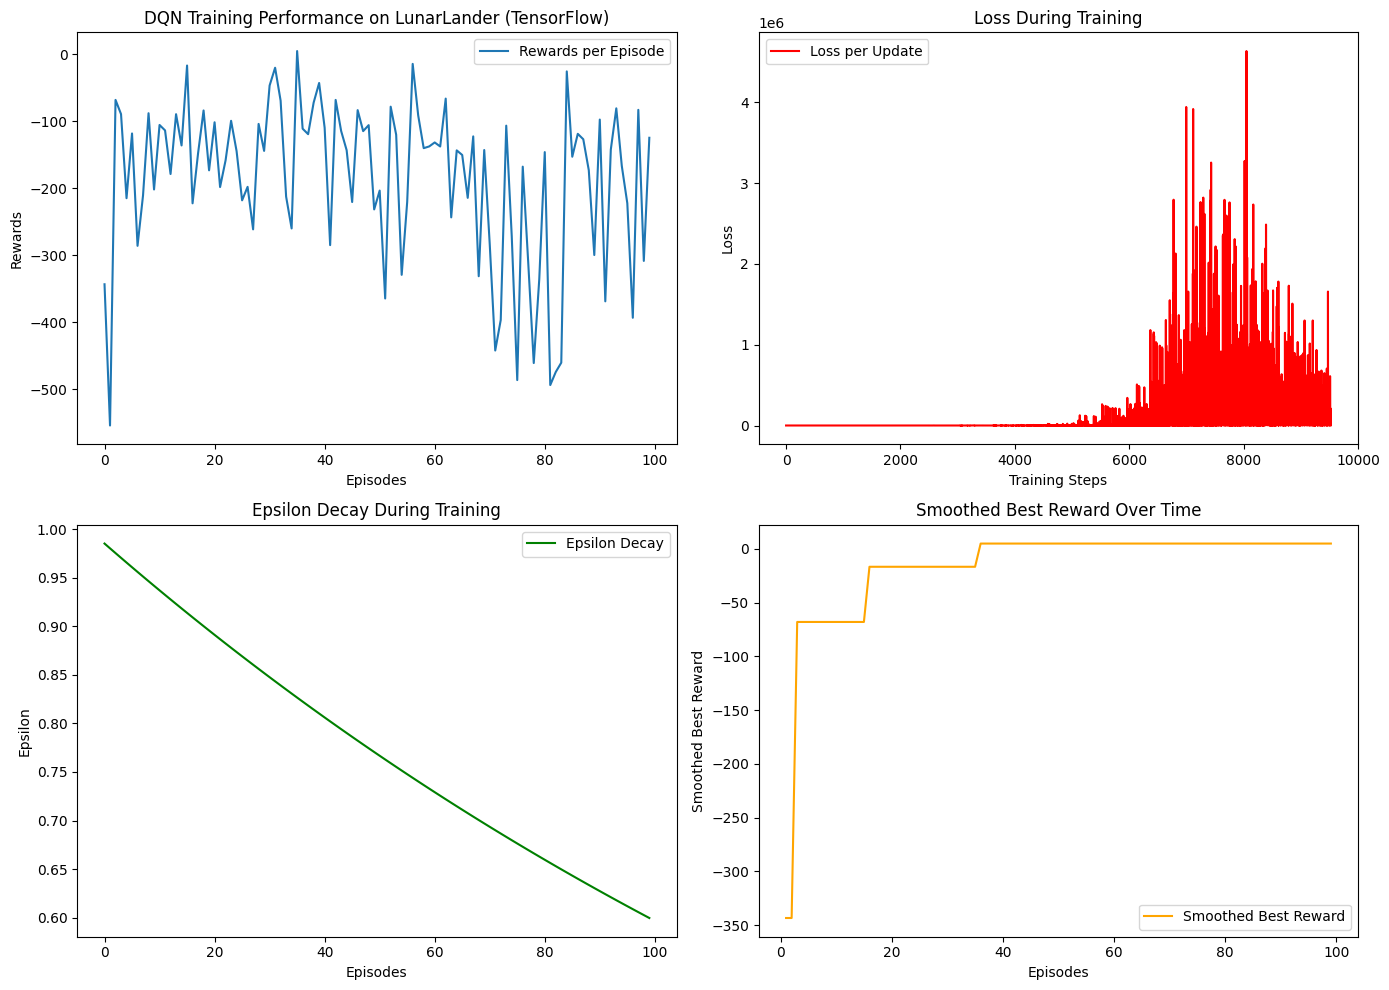

In [5]:
import gymnasium as gym
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import random
import matplotlib.pyplot as plt


class DQNNetworkTensor(tf.keras.Model):
    """Red neuronal para el agente DQN."""

    def __init__(self, input_dim, output_dim):
        super(DQNNetworkTensor, self).__init__()
        self.fc1 = layers.Dense(256, activation="relu", input_dim=input_dim)
        self.fc2 = layers.Dense(256, activation="relu")
        self.fc3 = layers.Dense(output_dim)

    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return self.fc3(x)


class DQNAgentTensor:
    def __init__(self, env_name="LunarLander-v3", episodes=1000, gamma=0.99, lr=0.001):
        self.env = gym.make(env_name)
        self.episodes = episodes
        self.gamma = gamma
        self.lr = lr
        self.epsilon = 0.99
        self.epsilon_min = 0.005
        self.epsilon_decay = 0.995
        self.memory = []
        self.batch_size = 128
        self.replay_buffer_capacity = 10000

        self.rewards_per_episode = []
        self.best_reward = -np.inf
        self.losses = []  # Pérdidas
        self.epsilon_values = []  # Epsilon decay
        self.best_rewards_per_episode = []  # Mejores recompensas

        # Dimensiones
        input_dim = self.env.observation_space.shape[0]
        output_dim = self.env.action_space.n

        # Inicializar la red y el optimizador
        self.network = DQNNetworkTensor(input_dim, output_dim)
        self.target_network = DQNNetworkTensor(input_dim, output_dim)
        self.target_network.set_weights(self.network.get_weights())

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr)
        self.loss_fn = tf.keras.losses.MeanSquaredError()

    def store_transition(self, state, action, reward, next_state, done):
        """Almacenar experiencias en la memoria de replay."""
        if len(self.memory) > self.replay_buffer_capacity:
            self.memory.pop(0)
        self.memory.append((state, action, reward, next_state, done))

    def sample_memory(self):
        """Obtener un batch aleatorio de la memoria."""
        return random.sample(self.memory, self.batch_size)

    def select_action(self, state):
        """Seleccionar acción utilizando la política epsilon-greedy."""
        if random.random() < self.epsilon:
            return self.env.action_space.sample()  # Acción aleatoria
        state = np.array(state).reshape(1, -1)  # Necesitamos la forma (1, input_dim)
        q_values = self.network(state, training=False)
        return np.argmax(q_values[0])

    def update_network(self):
        """Actualizar la red neuronal usando experiencias almacenadas."""
        if len(self.memory) < self.batch_size:
            return

        batch = self.sample_memory()
        states, actions, rewards, next_states, dones = zip(*batch)

        states = np.array(states)
        actions = np.array(actions)
        rewards = np.array(rewards)
        next_states = np.array(next_states)
        dones = np.array(dones).astype(float)

        with tf.GradientTape() as tape:
            # Predicciones de Q para los estados actuales
            q_values = self.network(states)
            # Predicción de Q para los estados futuros (red objetivo)
            next_q_values = self.target_network(next_states)
            max_next_q_values = np.max(next_q_values, axis=1)

            # Cálculo de la recompensa esperada
            expected_q_values = rewards + (1 - dones) * self.gamma * max_next_q_values

            # Seleccionar las Q-values correspondientes a las acciones tomadas
            q_values_taken = tf.reduce_sum(
                q_values * tf.one_hot(actions, self.env.action_space.n), axis=1
            )

            # Calcular la pérdida
            loss = self.loss_fn(expected_q_values, q_values_taken)

        # Aplicar el gradiente
        grads = tape.gradient(loss, self.network.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.network.trainable_variables))

        # Registrar la pérdida
        self.losses.append(loss.numpy())

    def train(self):
        for episode in range(1, self.episodes + 1):
            state, _ = self.env.reset()
            done = False
            total_reward = 0

            while not done:
                action = self.select_action(state)
                next_state, reward, done, _, _ = self.env.step(action)
                self.store_transition(state, action, reward, next_state, done)
                self.update_network()

                state = next_state
                total_reward += reward

            self.rewards_per_episode.append(total_reward)
            self.best_rewards_per_episode.append(self.best_reward)
            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
            self.epsilon_values.append(self.epsilon)

            # Actualizar la red objetivo periódicamente
            if episode % 5 == 0:
                self.target_network.set_weights(self.network.get_weights())

            # Guardar el modelo si es la mejor recompensa
            if total_reward > self.best_reward:
                self.best_reward = total_reward
                self.save_model()

            # Imprimir métricas cada 100 episodios
            mean_reward = np.mean(self.rewards_per_episode[-100:])
            print(
                f"Episode: {episode}, Epsilon: {self.epsilon:.2f}, "
                f"Best Reward: {self.best_reward:.1f}, Mean Reward: {mean_reward:.1f}"
            )

        self.plot_rewards()

    def save_model(self):
        """Guardar el modelo entrenado."""
        self.network.save("lunarlander_dqn_model_tensor.keras")

    def load_model(self):
        """Cargar el modelo entrenado."""
        self.network = keras.models.load_model("lunarlander_dqn_model_tensor.keras")
        self.update_target_network()

    def plot_rewards(self):
        """Graficar las recompensas acumuladas y métricas del entrenamiento."""
        plt.figure(figsize=(14, 10))

        # Graficar recompensas por episodio
        plt.subplot(2, 2, 1)
        plt.plot(self.rewards_per_episode, label="Rewards per Episode")
        plt.xlabel("Episodes")
        plt.ylabel("Rewards")
        plt.title("DQN Training Performance on LunarLander (TensorFlow)")
        plt.legend()

        # Graficar la pérdida
        plt.subplot(2, 2, 2)
        plt.plot(self.losses, label="Loss per Update", color="red")
        plt.xlabel("Training Steps")
        plt.ylabel("Loss")
        plt.title("Loss During Training")
        plt.legend()

        # Graficar la Epsilon Decay
        plt.subplot(2, 2, 3)
        plt.plot(self.epsilon_values, label="Epsilon Decay", color="green")
        plt.xlabel("Episodes")
        plt.ylabel("Epsilon")
        plt.title("Epsilon Decay During Training")
        plt.legend()

        # Graficar la mejor recompensa suavizada
        plt.subplot(2, 2, 4)
        # Promedio móvil para suavizar la curva de mejores recompensas
        # window_size = 50  # Tamaño de la ventana para el promedio móvil
        # best_rewards_smooth = np.convolve(
        #     self.best_rewards_per_episode,
        #     np.ones(window_size) / window_size,
        #     mode="valid",
        # )

        plt.plot(
            self.best_rewards_per_episode, label="Smoothed Best Reward", color="orange"
        )
        plt.xlabel("Episodes")
        plt.ylabel("Smoothed Best Reward")
        plt.title("Smoothed Best Reward Over Time")
        plt.legend()

        plt.tight_layout()
        plt.show()


if __name__ == "__main__":
    agent = DQNAgentTensor(episodes=100)
    agent.train()
